<a href="https://colab.research.google.com/github/abbasmammadov/Facial-Expression-Recognition/blob/main/Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
#mount your drive first - you can do it once
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#importing necessary modules
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

In [50]:
from collections import OrderedDict
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(OrderedDict([
    ('dropout1', nn.Dropout(p=0.5)), 
    ('fc1', nn.Linear(model.fc.in_features, 4096)), 
    ('relu1', nn.ReLU(inplace=True)), 
    ('dropout2', nn.Dropout(p=0.5)), 
    ('fc2', nn.Linear(4096, 1024)), 
    ('relu2', nn.ReLU(inplace=True)), 
    ('dropout3', nn.Dropout(p=0.5)), 
    ('fc4', nn.Linear(1024, 7)), 
]))
model_path = '/content/drive/MyDrive/ML Project Folder/Models'
best_model_path = os.path.join(model_path, 'best-resnet.h5')
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

In [37]:
#load the dataset, and get the data augmentation ready 
# in this case the data augmentation is only converting it to a normalized tensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
test_augs = T.ToTensor()

In [38]:
data_path = '/content/drive/MyDrive/ML Project Folder/project/datasets/fer2013'
# since we want to evaluate our model in our test dataset, we wll only load our test dataset
test_path = os.path.join(data_path, 'test')

# perform the data augmentation, and store the new dataset
testset = ImageFolder(test_path, transform=test_augs)

print(f"Total no. of examples in testset : {len(testset)}")

##let's load our test dataset in a format suitable to pytorch
testloader = DataLoader(testset)

Total no. of examples in testset : 3589


In [39]:
#the label encoding used in our CSV file -> encoding which maps to emotion 
em_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
num_classes = 7

In [41]:
#accuracy of the model
from tqdm import tqdm
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [42]:
def test_model(model, dataloader, current_epoch=1):
  # initialize the test tensors
  true_labels = torch.zeros((len(dataloader)))
  predictions = torch.zeros((len(dataloader)))
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TEST]' + str(current_epoch) + "/" + str(1))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits,  labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    predictions[t], true_labels[t] = logits.argmax(1), labels
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return {'loss': total_loss/len(dataloader), 'accuracy': total_acc / len(dataloader), 'predictions': predictions, 'true_labels': true_labels}

In [43]:
test_info = test_model(model, testloader)
test_loss, test_acc, predictions, true_labels = test_info['loss'], test_info['accuracy'], test_info['predictions'], test_info['true_labels']
print()
print('accuracy on the test set: ', float(test_acc))

EPOCH[TEST]1/1: 100%|██████████| 3589/3589 [01:56<00:00, 30.91it/s, loss=1.06, acc=0.613]


accuracy on the test set:  0.6127054691314697


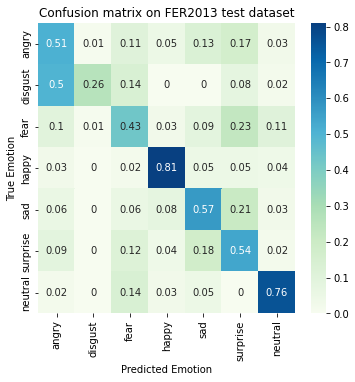

In [62]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

#build a heatmap which helps us to visualize the confusion matrix
conf_mat_colored = pd.DataFrame(confusion_matrix(true_labels, predictions, normalize='true').round(2), index=em_dict.values(), columns=em_dict.values())

#now plot it
plt.figure(figsize=(5,5))
heatmap(conf_mat_colored, annot=True, cmap=plt.cm.GnBu)
plt.tight_layout()
plt.title('Confusion matrix on FER2013 test dataset')
plt.ylabel('True Emotion')
plt.xlabel('Predicted Emotion')
plt.show()

your emotion: happy


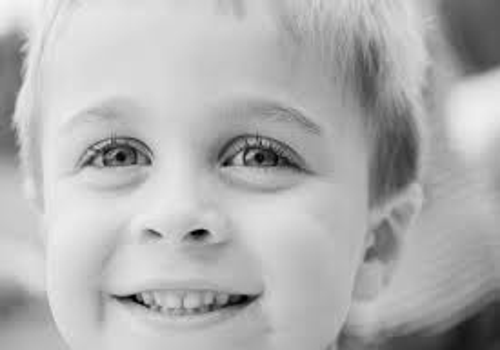

In [48]:
#try our model with your own image :)) => preferably a greyscale one :))
image_path = '/content/trial_image.jpg' # replace it with your image directory
my_image = Image.open(image_path) 
transforms= T.Compose([T.Resize((48, 48)), T.ToTensor()]) # call the transformations to convert the image to normalized tensors
single_loader = transforms(my_image).to(device)
pred_label_index = int(model(single_loader.unsqueeze(0)).argmax(1))
print('your emotion:', em_dict[pred_label_index])
my_image.resize((500, 350))